# **End-to-End Credit Risk Analysis and Default Prediction for Home Credit**

This project implements a comprehensive credit risk analysis process, from data exploration and feature engineering to machine learning modeling to predict potential defaults. The goal is to improve the accuracy of the loan approval process and reduce losses due to credit issues.

# **1. Import Library**
In this section, we import various libraries required for data analysis and modeling. Some of these libraries are used for data manipulation, visualization, and machine learning model implementation.

In [25]:
import os
import gc
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import early_stopping
import shap

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')

# **2. Load & Understanding Data**
In this section, load a dataset from a CSV file into a DataFrame using the pandas library.

### **2.1 Load Dataset**

In [26]:
# ## 1. Configuration & Utilities
DATA_DIR = Path('data')
OUTPUT_DIR = Path('models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42
N_FOLDS = 5

# quick utility to display dataframe summary
def df_info(df, name=None, n=5):
    print(f"--- {name or 'DataFrame'} info ---")
    print('shape:', df.shape)
    display(df.head(n))
    print('\nmissing value % (top 10):')
    miss = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(10)
    print(miss)

# function to reduce memory usage
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= -128 and c_max <= 127:
                    df[col] = df[col].astype('int8')
                elif c_min >= -32768 and c_max <= 32767:
                    df[col] = df[col].astype('int16')
                elif c_min >= -2147483648 and c_max <= 2147483647:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
            else:
                df[col] = df[col].astype('float32')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Mem. usage decreased to {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)')
    return df

# %% [markdown]
# ## 2. Load all datasets
files = {
    'app_train': 'application_train.csv',
    'app_test': 'application_test.csv',
    'bureau': 'bureau.csv',
    'bureau_balance': 'bureau_balance.csv',
    'prev_app': 'previous_application.csv',
    'pos_cash': 'POS_CASH_balance.csv',
    'cc_bal': 'credit_card_balance.csv',
    'inst_pay': 'installments_payments.csv',
    'columns_desc': 'HomeCredit_columns_description.csv'
}

# load with read_csv; we wrap with try/except so notebook continues even if file missing
data = {}
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']  # add more if needed

for k, fname in files.items():
    path = DATA_DIR / fname
    if path.exists():
        print('Loading', fname)
        for encoding in encodings_to_try:
            try:
                data[k] = pd.read_csv(path, encoding=encoding)
                print(f' - {k} shape:', data[k].shape)
                break  # if successful, break out of the encoding loop
            except UnicodeDecodeError:
                print(f' - Failed with encoding {encoding}, trying next...')
                continue
        else:
            print(f'Could not load {fname} with any of the tried encodings')
    else:
        print('File not found:', path)

# quick reduce mem for large tables
for k in ['app_train', 'app_test', 'bureau', 'prev_app', 'pos_cash', 'cc_bal', 'inst_pay', 'bureau_balance']:
    if k in data:
        data[k] = reduce_mem(data[k])

Loading application_train.csv
 - app_train shape: (307511, 122)
Loading application_test.csv
 - app_test shape: (48744, 121)
Loading bureau.csv
 - bureau shape: (1716428, 17)
Loading bureau_balance.csv
 - bureau_balance shape: (27299925, 3)
Loading previous_application.csv
 - prev_app shape: (1670214, 37)
Loading POS_CASH_balance.csv
 - pos_cash shape: (10001358, 8)
Loading credit_card_balance.csv
 - cc_bal shape: (3840312, 23)
Loading installments_payments.csv
 - inst_pay shape: (13605401, 8)
Loading HomeCredit_columns_description.csv
 - Failed with encoding utf-8, trying next...
 - columns_desc shape: (219, 5)
Mem. usage decreased to 128.16 MB (55.2% reduction)
Mem. usage decreased to 20.27 MB (55.0% reduction)
Mem. usage decreased to 119.49 MB (46.3% reduction)
Mem. usage decreased to 324.94 MB (31.1% reduction)
Mem. usage decreased to 276.60 MB (54.7% reduction)
Mem. usage decreased to 318.63 MB (52.7% reduction)
Mem. usage decreased to 389.25 MB (53.1% reduction)
Mem. usage decrea

### **2.2 Diplaying 5 Initial Data**

In [27]:
def show_head(df, name):
    print(f"\n=== INFO: {name} ===")
    print(df.head())

for name, df in data.items():
    show_head(df, name)


=== INFO: app_train ===
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...      

### **2.3 Dataset Information**

In [28]:
def show_info(df, name):
    print(f"\n=== INFO: {name} ===")
    print(df.info())

for name, df in data.items():
    show_info(df, name)


=== INFO: app_train ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(65), int16(2), int32(2), int8(37), object(16)
memory usage: 128.2+ MB
None

=== INFO: app_test ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(65), int16(2), int32(2), int8(36), object(16)
memory usage: 20.3+ MB
None

=== INFO: bureau ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float32
 7   DAYS_ENDDATE_FACT

#### **Insight**

- The largest dataset is **BUREAU_BALANCE** with **27 million entries** and **3 columns**.  
- **INSTALLMENTS_PAYMENTS** and **POS_CASH_BALANCE** are also large, with **13.6 million** and **10 million entries**, respectively.  
- **APPLICATION_TRAIN** contains **307,511 entries** with **122 columns**, the largest compared to other application datasets.  
- **PREVIOUS_APPLICATION** dataset has **1.67 million entries** with **37 columns** detailing previous loan applications.  
- **CREDIT_CARD_BALANCE** stores credit card transaction data with **3.8 million entries** and **23 columns**.  
- The data types are dominated by a combination of **float64**, **int64**, and **object (category/string)**.  
- **SAMPLE_SUBMISSION** contains **48,744 entries** with target labels for model prediction.  
- The dataset contains a combination of **time (date/month)** and **contract status** data, which are important for behavioral analysis.  
- The complexity of the data requires **efficient storage and processing optimization**.  
- The number of columns ranges from **3 (Bureau Balance)** to **122 (Application Train)**, indicating a wide variety of features.


### **2.4 Statical Description**

In [29]:
def show_describe(df, name):
    print(f"\n=== DESCRIBE: {name} ===")
    display(df.describe(include='all'))

for name, df in data.items():
    show_describe(df, name)  



=== DESCRIBE: app_train ===


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990259e+05,27108.572266,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737305,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000



=== DESCRIBE: app_test ===


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744,48744,48744,48744,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,48305,32678,32311,33658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,277796.676350,NaN,NaN,NaN,NaN,0.397054,1.784318e+05,5.167404e+05,29426.238281,4.626188e+05,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,NaN,NaN,NaN,NaN,0.709047,1.015226e+05,3.653970e+05,16016.368164,3.367102e+05,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,NaN,NaN,NaN,NaN,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,NaN,NaN,NaN,NaN,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,NaN,NaN,NaN,NaN,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000



=== DESCRIBE: bureau ===


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105173e+02,-1.017437e+03,3.825417e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229514e+03,3.791277e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04



=== DESCRIBE: bureau_balance ===


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN



=== DESCRIBE: prev_app ===


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,...,1670214,1.297984e+06,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,...,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,...,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.595512e+04,1.752339e+05,1.961140e+05,6.697401e+03,2.278472e+05,NaN,1.248418e+01,...,NaN,1.605408e+01,NaN,NaN,342209.781250,13826.266602,33767.769531,76582.406250,81992.343750,0.332570
std,5.325980e+05,1.028148e+05,NaN,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,NaN,3.334028e+00,...,NaN,1.456729e+01,NaN,NaN,88916.117188,72444.867188,106857.039062,149647.421875,153303.515625,0.471134
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,...,NaN,0.000000e+00,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,...,NaN,6.000000e+00,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,...,NaN,1.200000e+01,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,...,NaN,2.400000e+01,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000



=== DESCRIBE: pos_cash ===


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,10001358,1.000136e+07,1.000136e+07
unique,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,9151119,NaN,NaN
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708964e+01,1.048384e+01,NaN,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,NaN,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,NaN,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,NaN,0.000000e+00,0.000000e+00



=== DESCRIBE: cc_bal ===


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961323e+03,7.433390e+03,2.881696e+02,2.968804e+03,3.540206e+03,...,5.808884e+04,5.809825e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082509e+01,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,NaN,0.000000e+00,0.000000e+00



=== DESCRIBE: inst_pay ===


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705092e+04,1.723821e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473579e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



=== DESCRIBE: columns_desc ===


,Unnamed: 0,Table,Row,Description,Special
count,219.000000,219,219,219,86
unique,NaN,7,196,163,7
top,NaN,application_{train|test}.csv,SK_ID_CURR,Normalized information about building where th...,normalized
freq,NaN,122,6,47,53
mean,111.981735,NaN,NaN,NaN,NaN
std,63.395726,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN
25%,57.500000,NaN,NaN,NaN,NaN
50%,112.000000,NaN,NaN,NaN,NaN
75%,166.500000,NaN,NaN,NaN,NaN


#### **Insight**

- The primary dataset is dominated by **female** borrowers using **cash loan** products, with an average income of **Rp168-178 million/year** and an average loan of **Rp500-600 million**. The data shows an imbalance with **8% of borrowers in default**.

- Prior credit history is predominantly **Closed** with an active loan duration of around **3 years**, and loan payments are generally recorded as **C (active/paid off)** for around **30 months**.

- Credit card usage is predominantly **Active**, with an average balance of around **Rp58,000** and an average credit limit of **Rp153,000**. ATM transactions average around **Rp5,960** per withdrawal.

- The average installment payment is around **Rp17,238** per installment with payment delays of around **11 days**. Most installment contracts are **Active**.

- There are millions of previous loan applications with an approval rate of around **62%**. The most common loan purpose is the **XAP (unspecified)** category, with an average approval process of **880 days**.

- **Conclusion:**
    - **Cash loan products** are dominated by **female borrowers**.
    - **Default data shows an imbalance** (ratio 8:92).
    - **Credit history and installment payments** are important for risk analysis.
    - Special attention is needed to detect **outliers in income and credit limits**.

### **2.5 Check Missing Value**

In [30]:
def show_missing(df, name):
    print(f"\n=== {name} ===")
    miss = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    print(miss[miss > 0].head(10))

for name, df in data.items():
    show_missing(df, name)


=== app_train ===
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64

=== app_test ===
COMMONAREA_AVG              68.716150
COMMONAREA_MEDI             68.716150
COMMONAREA_MODE             68.716150
NONLIVINGAPARTMENTS_AVG     68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
NONLIVINGAPARTMENTS_MODE    68.412523
FONDKAPREMONT_MODE          67.284179
LIVINGAPARTMENTS_MEDI       67.249302
LIVINGAPARTMENTS_AVG        67.249302
LIVINGAPARTMENTS_MODE       67.249302
dtype: float64

=== bureau ===
AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SU

#### **Insight**

- **APPLICATION_TEST**: Missing values mainly appear in **credit request columns (~6,049)**, while **key identity columns have none**.

- **APPLICATION_TRAIN**: Similar pattern with large missing data in **credit request columns (~41,519)**, but **target variable is complete**.

- **BUREAU_BALANCE**: **No missing values**; data is complete for monthly credit payment history.

- **BUREAU**: Significant missing values in **date and credit amount columns**, while **identity and status columns are complete**.

- **CREDIT_CARD_BALANCE**: Large missing values (~750,000) in some **transaction-related columns**; **balance and limit info mostly complete**.

- **HOMECREDIT_COLUMNS_DESCRIPTION**: Missing values present only in the "**Special**" column.

- **INSTALLMENTS_PAYMENTS**: Missing values in **payment entry date and amount (~2,905 entries)**.

- **POS_CASH_BALANCE**: Missing values (~26,000) in **installment count columns**; other data complete.

- **PREVIOUS_APPLICATION**: Large missing values in many **financial columns (hundreds of thousands to millions)**, but **key ID and contract columns complete**.

- **SAMPLE_SUBMISSION**: **Complete with no missing values**.

#### **General Conclusions**
- **Key identity and status columns across datasets have no missing values**, preserving data integrity.  
- Missing data is prevalent in **detailed financial and date-related fields**, requiring careful imputation or handling.  
- Cleaning and imputation are crucial, especially for supporting datasets with **significant missing entries**, to ensure reliable analysis and modeling.


### **2.6 Check Duplicates**

In [31]:
def show_duplicates(df, name):
    print(f"\n=== DUPLICATES: {name} ===")
    dup_count = df.duplicated().sum()
    print(f"Total duplicate rows: {dup_count}")
    
for name, df in data.items():
    show_duplicates(df, name)


=== DUPLICATES: app_train ===
Total duplicate rows: 0

=== DUPLICATES: app_test ===
Total duplicate rows: 0

=== DUPLICATES: bureau ===
Total duplicate rows: 0

=== DUPLICATES: bureau_balance ===
Total duplicate rows: 0

=== DUPLICATES: prev_app ===
Total duplicate rows: 0

=== DUPLICATES: pos_cash ===
Total duplicate rows: 0

=== DUPLICATES: cc_bal ===
Total duplicate rows: 0

=== DUPLICATES: inst_pay ===
Total duplicate rows: 0

=== DUPLICATES: columns_desc ===
Total duplicate rows: 0


#### **Insight Check Duplicates**

- All analyzed datasets **contain no duplicate data at all**, both in large datasets such as **application_train**, **bureau_balance**, and other supporting datasets.

- Overall, **data quality in terms of duplication is guaranteed**, thus providing a **strong foundation for analysis and risk prediction model development**.

### **2.7 Detect Outlier**

In [32]:
from scipy import stats

def detect_outliers_iqr_zscore(df, name, z_thresh=3):
    print(f"\n=== OUTLIERS DETECTION (IQR & Z-Score): {name} ===")
    num_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in num_cols:
        # --- IQR Method ---
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        iqr_ratio = iqr_outliers / len(df) * 100

        # --- Z-Score Method ---
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
        z_outliers = (z_scores > z_thresh).sum()
        z_ratio = z_outliers / len(df) * 100

        results.append({
            'feature': col,
            'iqr_outlier_count': iqr_outliers,
            'iqr_outlier_ratio_%': iqr_ratio,
            'z_outlier_count': z_outliers,
            'z_outlier_ratio_%': z_ratio
        })

    df_results = pd.DataFrame(results)

    # --- Summary statistics ---
    summary = {
        'total_iqr_outliers': df_results['iqr_outlier_count'].sum(),
        'avg_iqr_count': df_results['iqr_outlier_count'].mean(),
        'avg_iqr_ratio_%': df_results['iqr_outlier_ratio_%'].mean(),
        'total_z_outliers': df_results['z_outlier_count'].sum(),
        'avg_z_count': df_results['z_outlier_count'].mean(),
        'avg_z_ratio_%': df_results['z_outlier_ratio_%'].mean()
    }

    print("\n--- Summary ---")
    for k, v in summary.items():
        if "_%" in k:
            print(f"{k}: {v:.2f}")
        else:
            print(f"{k}: {int(v)}")

    # --- Scrollable output ---
    display(display_scrollable(df_results.sort_values(by='iqr_outlier_count', ascending=False), max_height=300))

# --- Call the function for all datasets ---
for name, df in data.items():
    detect_outliers_iqr_zscore(df, name)



=== OUTLIERS DETECTION (IQR & Z-Score): app_train ===

--- Summary ---
total_iqr_outliers: 1268424
avg_iqr_count: 11966
avg_iqr_ratio_%: 3.89
total_z_outliers: 328621
avg_z_count: 3100
avg_z_ratio_%: 1.01


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
20,REGION_RATING_CLIENT,80527,26.186706,0,0.000000
21,REGION_RATING_CLIENT_W_CITY,78027,25.373726,0,0.000000
9,DAYS_EMPLOYED,72217,23.484363,0,0.000000
27,REG_CITY_NOT_WORK_CITY,70867,23.045354,0,0.000000
15,FLAG_WORK_PHONE,61308,19.936848,0,0.000000
14,FLAG_EMP_PHONE,55386,18.011063,0,0.000000
28,LIVE_CITY_NOT_WORK_CITY,55215,17.955455,0,0.000000
104,AMT_REQ_CREDIT_BUREAU_QRT,50575,16.446566,2301,0.748266
103,AMT_REQ_CREDIT_BUREAU_MON,43759,14.230060,3235,1.051995
76,DEF_30_CNT_SOCIAL_CIRCLE,35166,11.435688,6838,2.223660



=== OUTLIERS DETECTION (IQR & Z-Score): app_test ===

--- Summary ---
total_iqr_outliers: 199915
avg_iqr_count: 1903
avg_iqr_ratio_%: 3.91
total_z_outliers: 42961
avg_z_count: 409
avg_z_ratio_%: 0.84


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
19,REGION_RATING_CLIENT,13388,27.465945,0,0.000000
20,REGION_RATING_CLIENT_W_CITY,12968,26.604300,1,0.002052
8,DAYS_EMPLOYED,11630,23.859347,0,0.000000
26,REG_CITY_NOT_WORK_CITY,10951,22.466355,0,0.000000
80,FLAG_DOCUMENT_3,10401,21.338011,0,0.000000
14,FLAG_WORK_PHONE,9978,20.470212,0,0.000000
13,FLAG_EMP_PHONE,9275,19.027983,0,0.000000
27,LIVE_CITY_NOT_WORK_CITY,8492,17.421631,0,0.000000
17,FLAG_EMAIL,7928,16.264566,0,0.000000
75,DEF_30_CNT_SOCIAL_CIRCLE,5520,11.324471,1077,2.209503



=== OUTLIERS DETECTION (IQR & Z-Score): bureau ===

--- Summary ---
total_iqr_outliers: 868752
avg_iqr_count: 62053
avg_iqr_ratio_%: 3.62
total_z_outliers: 99455
avg_z_count: 7103
avg_z_ratio_%: 0.41


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
9,AMT_CREDIT_SUM_DEBT,280455,16.339456,15543,0.905543
8,AMT_CREDIT_SUM,187998,10.952863,16756,0.976213
6,AMT_CREDIT_MAX_OVERDUE,121290,7.066419,199,0.011594
4,DAYS_CREDIT_ENDDATE,79340,4.622390,38630,2.250604
10,AMT_CREDIT_SUM_LIMIT,74506,4.340759,15704,0.914923
12,DAYS_CREDIT_UPDATE,63755,3.714400,1409,0.082089
13,AMT_ANNUITY,43918,2.558686,460,0.026800
7,CNT_CREDIT_PROLONG,9114,0.530986,9114,0.530986
3,CREDIT_DAY_OVERDUE,4217,0.245685,1194,0.069563
11,AMT_CREDIT_SUM_OVERDUE,4158,0.242247,445,0.025926



=== OUTLIERS DETECTION (IQR & Z-Score): bureau_balance ===

--- Summary ---
total_iqr_outliers: 0
avg_iqr_count: 0
avg_iqr_ratio_%: 0.00
total_z_outliers: 0
avg_z_count: 0
avg_z_ratio_%: 0.00


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
0,SK_ID_BUREAU,0,0.0,0,0.0
1,MONTHS_BALANCE,0,0.0,0,0.0



=== OUTLIERS DETECTION (IQR & Z-Score): prev_app ===

--- Summary ---
total_iqr_outliers: 1707804
avg_iqr_count: 81324
avg_iqr_ratio_%: 4.87
total_z_outliers: 436353
avg_z_count: 20778
avg_z_ratio_%: 1.24


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
13,SELLERPLACE_AREA,268087,16.051057,1451,0.086875
19,DAYS_TERMINATION,225913,13.525991,0,0.000000
18,DAYS_LAST_DUE,211221,12.646344,0,0.000000
3,AMT_APPLICATION,208019,12.454632,50112,3.000334
4,AMT_CREDIT,179989,10.776404,46983,2.812993
6,AMT_GOODS_PRICE,145715,8.724331,31311,1.874670
17,DAYS_LAST_DUE_1ST_VERSION,93865,5.619939,93864,5.619879
2,AMT_ANNUITY,82762,4.955173,23012,1.377788
5,AMT_DOWN_PAYMENT,64402,3.855913,6288,0.376479
15,DAYS_FIRST_DRAWING,62705,3.754309,62705,3.754309



=== OUTLIERS DETECTION (IQR & Z-Score): pos_cash ===

--- Summary ---
total_iqr_outliers: 1602703
avg_iqr_count: 228957
avg_iqr_ratio_%: 2.29
total_z_outliers: 560225
avg_z_count: 80032
avg_z_ratio_%: 0.80


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
4,CNT_INSTALMENT_FUTURE,694783,6.946887,257366,2.573311
3,CNT_INSTALMENT,498724,4.986563,214933,2.149038
5,SK_DPD,295227,2.951869,83290,0.832787
6,SK_DPD_DEF,113969,1.139535,4636,0.046354
2,MONTHS_BALANCE,0,0.000000,0,0.000000
0,SK_ID_PREV,0,0.000000,0,0.000000
1,SK_ID_CURR,0,0.000000,0,0.000000



=== OUTLIERS DETECTION (IQR & Z-Score): cc_bal ===

--- Summary ---
total_iqr_outliers: 5063513
avg_iqr_count: 230159
avg_iqr_ratio_%: 5.99
total_z_outliers: 1130638
avg_z_count: 51392
avg_z_ratio_%: 1.34


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
6,AMT_DRAWINGS_CURRENT,616869,16.062992,74963,1.952003
16,CNT_DRAWINGS_CURRENT,610360,15.893500,58069,1.512091
5,AMT_DRAWINGS_ATM_CURRENT,424778,11.061028,56203,1.463501
15,CNT_DRAWINGS_ATM_CURRENT,424778,11.061028,68941,1.795193
4,AMT_CREDIT_LIMIT_ACTUAL,404927,10.544117,103389,2.692203
11,AMT_PAYMENT_TOTAL_CURRENT,324742,8.456136,47142,1.227557
10,AMT_PAYMENT_CURRENT,282428,7.354298,42209,1.099103
18,CNT_DRAWINGS_POS_CURRENT,264902,6.897929,46701,1.216073
8,AMT_DRAWINGS_POS_CURRENT,264901,6.897903,38219,0.995206
12,AMT_RECEIVABLE_PRINCIPAL,250529,6.523663,103592,2.697489



=== OUTLIERS DETECTION (IQR & Z-Score): inst_pay ===

--- Summary ---
total_iqr_outliers: 4554830
avg_iqr_count: 569353
avg_iqr_ratio_%: 4.18
total_z_outliers: 813608
avg_z_count: 101701
avg_z_ratio_%: 0.75


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
3,NUM_INSTALMENT_NUMBER,1886320,13.864494,383116,2.815911
7,AMT_PAYMENT,1130093,8.306209,130578,0.959751
6,AMT_INSTALMENT,1120800,8.237905,119360,0.877299
2,NUM_INSTALMENT_VERSION,417616,3.069487,180553,1.327069
5,DAYS_ENTRY_PAYMENT,1,0.000007,1,0.000007
1,SK_ID_CURR,0,0.000000,0,0.000000
0,SK_ID_PREV,0,0.000000,0,0.000000
4,DAYS_INSTALMENT,0,0.000000,0,0.000000



=== OUTLIERS DETECTION (IQR & Z-Score): columns_desc ===

--- Summary ---
total_iqr_outliers: 0
avg_iqr_count: 0
avg_iqr_ratio_%: 0.00
total_z_outliers: 0
avg_z_count: 0
avg_z_ratio_%: 0.00


,feature,iqr_outlier_count,iqr_outlier_ratio_%,z_outlier_count,z_outlier_ratio_%
0,Unnamed: 0,0,0.0,0,0.0


#### **Insight Dataset Outliers**
- The **application_train** and **application_test** datasets have a significant number of outliers in the columns related to region rating, employment duration, and phone flag, with an average outlier ratio of around 3.9%. This indicates that the data contains extreme values that require attention during analysis.

- Datasets such as **credit_card_balance** and **installments_payments** show higher outlier ratios (reaching around 6% and 4.2%), particularly in the transaction and payment value columns, indicating large variations or possible extremes in financial activity.

- **bureau** and **previous_application** also contain significant outliers, particularly in the credit score and loan duration, which are relevant for analyzing borrower risk and credit history.

- The **bureau_balance** and **sample_submission** datasets contain no outliers, indicating more stable or cleaner data in their numeric columns.

- The average outlier ratio per column across all datasets is around **2%–6%**, so outlier detection and handling are critical to ensuring the quality of predictive models and accurate financial analysis.

# **3. Exploratory Data Analysis**

#### **3.1 Quick EDA on main application table**

--- application_train info ---
shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0



missing value % (top 10):
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64

Target distribution:


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

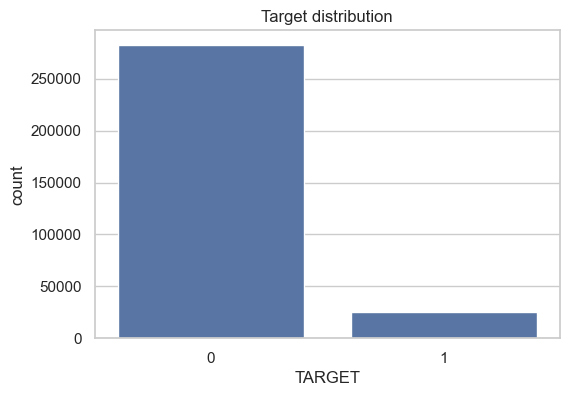

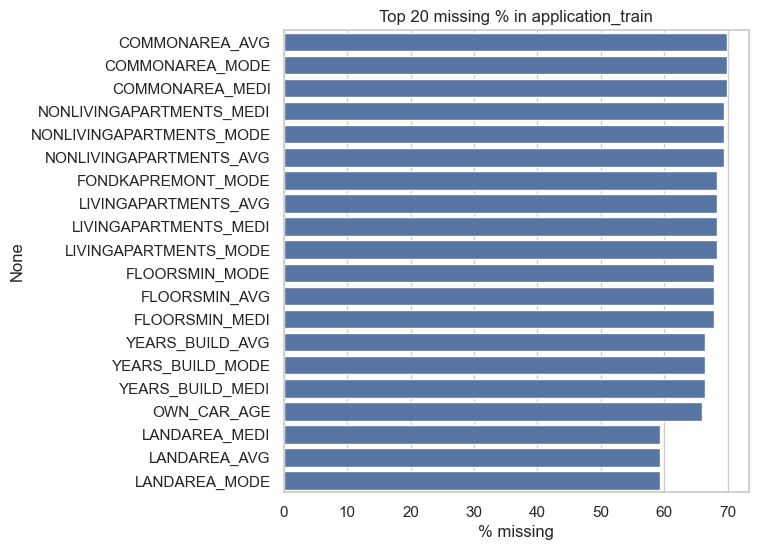

In [33]:
app = data.get('app_train')
app_test = data.get('app_test')

if app is not None:
    df_info(app, 'application_train')
    print('\nTarget distribution:')
    display(app['TARGET'].value_counts(normalize=True))

    plt.figure(figsize=(6,4))
    sns.countplot(x='TARGET', data=app)
    plt.title('Target distribution')
    plt.show()

    # Missingness top
    miss = (app.isnull().sum() / len(app) * 100).sort_values(ascending=False).head(20)
    plt.figure(figsize=(6,6))
    sns.barplot(y=miss.index, x=miss.values)
    plt.title('Top 20 missing % in application_train')
    plt.xlabel('% missing')
    plt.show()


#### **3.2 Numeric features vs target**

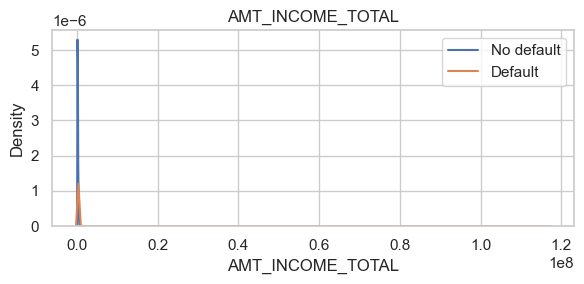

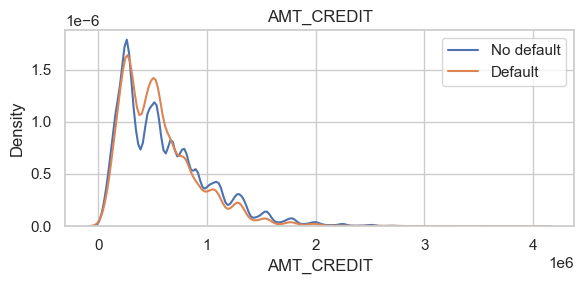

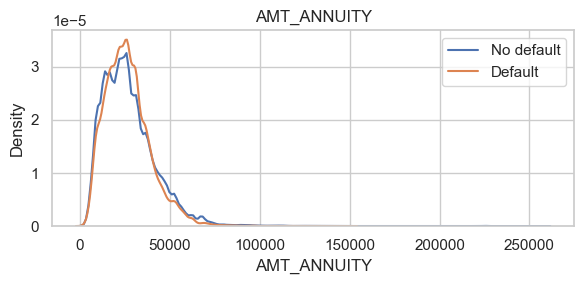

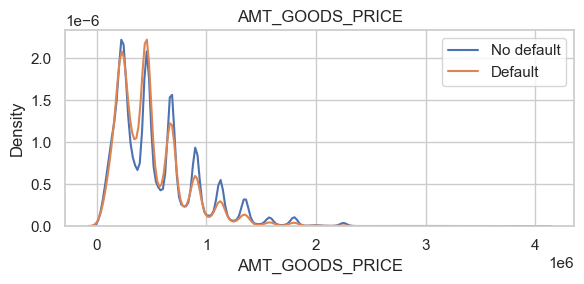

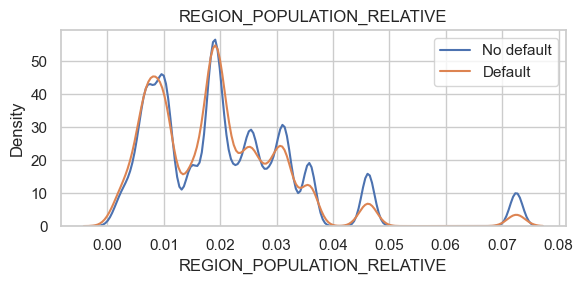

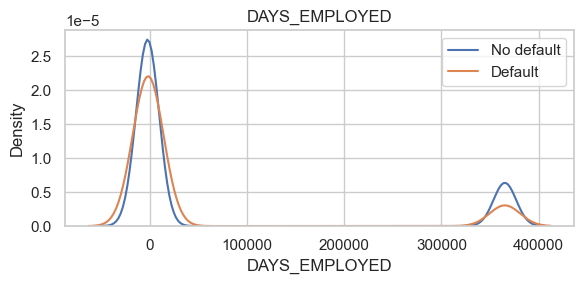

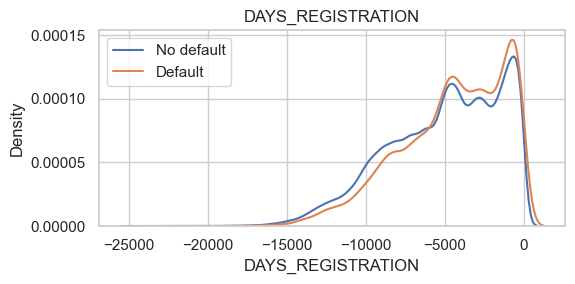

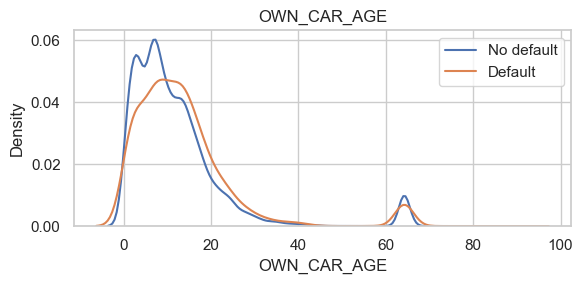

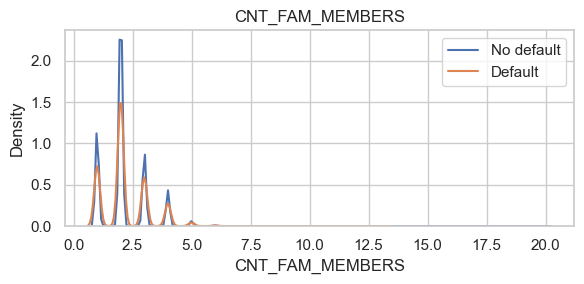

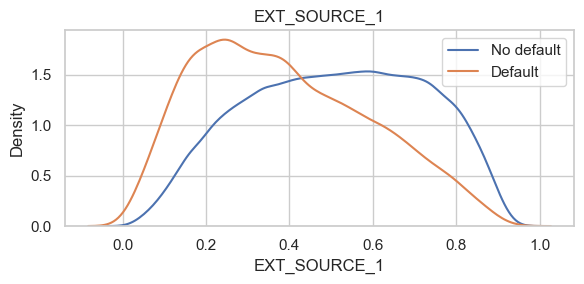

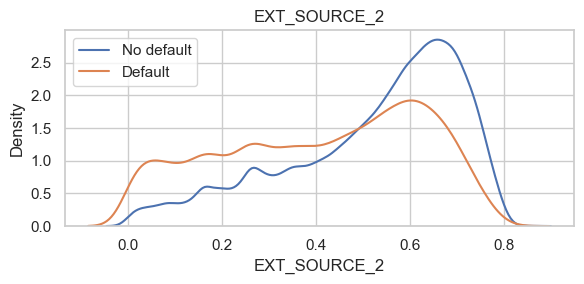

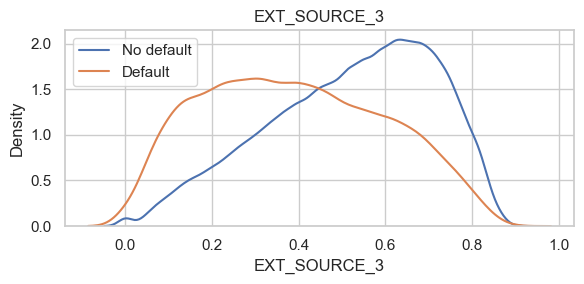

In [34]:
if app is not None:
    num_cols = app.select_dtypes(include=['int64', 'float32', 'float64', 'int32']).columns.tolist()
    # remove ID & target
    num_cols = [c for c in num_cols if c not in ['SK_ID_CURR', 'TARGET']]
    sample_num = num_cols[:12]
    for col in sample_num:
        plt.figure(figsize=(6,3))
        sns.kdeplot(app.loc[app['TARGET']==0, col].dropna(), label='No default')
        sns.kdeplot(app.loc[app['TARGET']==1, col].dropna(), label='Default')
        plt.title(col)
        plt.legend()
        plt.tight_layout()
        plt.show()

# **3.3 Categorical features - bad rate**

In [35]:
if app is not None:
    cat_cols = app.select_dtypes(include=['object']).columns.tolist()
    # easy bad rate for top categorical features
    for col in cat_cols[:6]:
        br = app.groupby(col)['TARGET'].mean().sort_values(ascending=False)
        display(br.head(10))

NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

CODE_GENDER
M      0.101419
F      0.069993
XNA    0.000000
Name: TARGET, dtype: float64

FLAG_OWN_CAR
N    0.085002
Y    0.072437
Name: TARGET, dtype: float64

FLAG_OWN_REALTY
N    0.083249
Y    0.079616
Name: TARGET, dtype: float64

NAME_TYPE_SUITE
Other_B            0.098305
Other_A            0.087760
Group of people    0.084871
Unaccompanied      0.081830
Spouse, partner    0.078716
Family             0.074946
Children           0.073768
Name: TARGET, dtype: float64

NAME_INCOME_TYPE
Maternity leave         0.400000
Unemployed              0.363636
Working                 0.095885
Commercial associate    0.074843
State servant           0.057550
Pensioner               0.053864
Businessman             0.000000
Student                 0.000000
Name: TARGET, dtype: float64

# **4. Data Preprocessing**

#### **4.1 Aggregation Data**

In [36]:
# Aggregation helpers for related tables
# Create functions to aggregate each related table to SK_ID_CURR level

def agg_bureau(bureau_df, bureau_balance_df=None):
    # Basic bureau aggregates per SK_ID_CURR
    agg_funcs = {
        'DAYS_CREDIT': ['min','max','mean'],
        'CREDIT_ACTIVE': ['nunique'],
        'AMT_CREDIT_SUM': ['sum','mean','max'],
        'AMT_CREDIT_SUM_DEBT': ['sum','mean']
    }
    # safe if cols not present
    cols = [c for c in agg_funcs.keys() if c in bureau_df.columns]
    if not cols:
        return pd.DataFrame()
    out = bureau_df.groupby('SK_ID_CURR')[cols].agg(agg_funcs)
    out.columns = ['BUREAU_'+'_'.join(col).strip() for col in out.columns.values]
    out.reset_index(inplace=True)
    return out


def agg_prev_app(prev_df):
    if prev_df is None or 'SK_ID_CURR' not in prev_df.columns:
        return pd.DataFrame()
    aggs = {
        'AMT_APPLICATION': ['count','mean','max'],
        'AMT_CREDIT': ['mean','max'],
        'NAME_CONTRACT_STATUS': ['nunique']
    }
    cols = [c for c in aggs.keys() if c in prev_df.columns]
    out = prev_df.groupby('SK_ID_CURR')[cols].agg(aggs)
    out.columns = ['PREVAPP_'+'_'.join(col).strip() for col in out.columns.values]
    out.reset_index(inplace=True)
    return out


def agg_payments(inst_df):
    if inst_df is None or 'SK_ID_CURR' not in inst_df.columns:
        return pd.DataFrame()
    aggs = {
        'AMT_INSTALMENT': ['sum','mean'],
        'AMT_PAYMENT': ['sum','mean'],
        'DAYS_ENTRY_PAYMENT': ['min','max','mean']
    }
    cols = [c for c in aggs.keys() if c in inst_df.columns]
    out = inst_df.groupby('SK_ID_CURR')[cols].agg(aggs)
    out.columns = ['PAY_'+'_'.join(col).strip() for col in out.columns.values]
    out.reset_index(inplace=True)
    return out


# Create joined dataset with aggregates
app_main = data.get('app_train').copy() if 'app_train' in data else None
app_main_test = data.get('app_test').copy() if 'app_test' in data else None

# aggregates
bureau_agg = agg_bureau(data.get('bureau'), data.get('bureau_balance')) if 'bureau' in data else pd.DataFrame()
prev_agg = agg_prev_app(data.get('prev_app')) if 'prev_app' in data else pd.DataFrame()
pay_agg = agg_payments(data.get('inst_pay')) if 'inst_pay' in data else pd.DataFrame()

print('Aggregates shapes:', bureau_agg.shape, prev_agg.shape, pay_agg.shape)

# merge to train
if app_main is not None:
    df = app_main.merge(bureau_agg, on='SK_ID_CURR', how='left')
    df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
    df = df.merge(pay_agg, on='SK_ID_CURR', how='left')
    print('Merged train shape:', df.shape)

# merge to test
if app_main_test is not None:
    df_test = app_main_test.merge(bureau_agg, on='SK_ID_CURR', how='left')
    df_test = df_test.merge(prev_agg, on='SK_ID_CURR', how='left')
    df_test = df_test.merge(pay_agg, on='SK_ID_CURR', how='left')
    print('Merged test shape:', df_test.shape)

# free memory
del app_main, app_main_test
gc.collect()


Aggregates shapes: (305811, 10) (338857, 7) (339587, 8)
Merged train shape: (307511, 144)
Merged test shape: (48744, 143)


70061

#### **4.2 Feature Engineering**

In [37]:
# Add ratio features, simple imputations, categorical encoding for low-cardinality
def simple_fe(df):
    df = df.copy()
    # ratio: credit to income
    if 'AMT_CREDIT' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
        df['RATIO_CREDIT_INCOME'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    # employment length -> flag
    if 'DAYS_EMPLOYED' in df.columns:
        df['EMPLOYED_POS'] = (df['DAYS_EMPLOYED'] < 0).astype(int)
    # annuity to income
    if 'AMT_ANNUITY' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
        df['ANNUITY_TO_INCOME'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    # previous application count
    if 'PREVAPP_AMT_APPLICATION_count' in df.columns:
        df['PREV_APP_COUNT'] = df['PREVAPP_AMT_APPLICATION_count']
    # missed payments indicator (from PAY aggregates)
    if 'PAY_AMT_PAYMENT_sum' in df.columns and 'PAY_AMT_INSTALMENT_sum' in df.columns:
        df['PAYMENT_RATIO'] = df['PAY_AMT_PAYMENT_sum'] / (df['PAY_AMT_INSTALMENT_sum'] + 1)
    return df


df = simple_fe(df) if 'df' in globals() else None
if 'df_test' in globals():
    df_test = simple_fe(df_test)

#### **4.3 Encode categoricals and fill missing**

In [38]:
def preprocess_for_model(train_df, test_df, target_col='TARGET'):
    train = train_df.copy()
    test = test_df.copy()

    # store ids
    train_ids = train['SK_ID_CURR']
    test_ids = test['SK_ID_CURR']

    # drop ID
    train.drop(columns=['SK_ID_CURR'], inplace=True)
    test.drop(columns=['SK_ID_CURR'], inplace=True)

    # keep target
    y = None
    if target_col in train.columns:
        y = train[target_col].copy()
        train.drop(columns=[target_col], inplace=True)

    # label encode binary object columns
    obj_cols = train.select_dtypes('object').columns.tolist()
    for col in obj_cols:
        # fit on train categories
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')
        # align categories
        test[col] = test[col].cat.set_categories(train[col].cat.categories)
        # fill na with 'MISSING'
        train[col] = train[col].cat.add_categories(['MISSING']).fillna('MISSING')
        test[col] = test[col].cat.add_categories(['MISSING']).fillna('MISSING')
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

    # numeric fill
    num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        if train[col].isnull().sum() > 0:
            med = train[col].median()
            train[col].fillna(med, inplace=True)
            test[col].fillna(med, inplace=True)

    # align
    train, test = train.align(test, join='inner', axis=1)
    return train, test, y, train_ids, test_ids

train_X, test_X, y, train_ids, test_ids = preprocess_for_model(df, df_test, target_col='TARGET')
print('train_X shape:', train_X.shape)
print('test_X shape:', test_X.shape)
print('y shape:', y.shape)

train_X shape: (307511, 147)
test_X shape: (48744, 147)
y shape: (307511,)


# **5. Build Model & Train Model**

#### **5.1 Build Model**

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16927
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.815285	valid's auc: 0.76769
[400]	train's auc: 0.853329	valid's auc: 0.769089
Early stopping, best iteration is:
[346]	train's auc: 0.844647	valid's auc: 0.769321
Fold 1 AUC: 0.76932
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

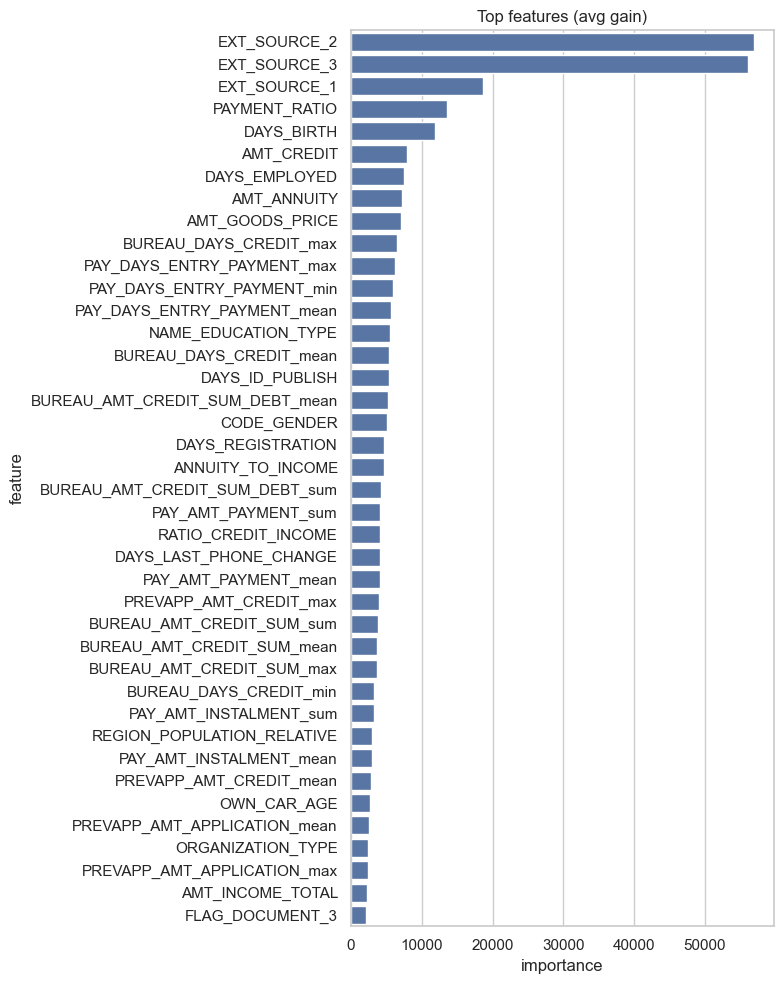

In [39]:
# Modeling: LightGBM with Stratified KFold CV
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'seed': RANDOM_STATE
}

folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Update the modeling section (section 10) to:
oof_preds = np.zeros(train_X.shape[0])
sub_preds = np.zeros(test_X.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_X, y)):
    train_data = lgb.Dataset(train_X.iloc[train_idx], label=y.iloc[train_idx])
    valid_data = lgb.Dataset(train_X.iloc[valid_idx], label=y.iloc[valid_idx])
    
    # Option 1: Use callbacks for early stopping
    clf = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        callbacks=[
            early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(200)
        ]
    )
    
    # Option 2: LightGBM Callback
    oof_preds[valid_idx] = clf.predict(train_X.iloc[valid_idx], num_iteration=clf.best_iteration)
    sub_preds += clf.predict(test_X, num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance['feature'] = train_X.columns
    fold_importance['importance'] = clf.feature_importance(importance_type='gain')
    fold_importance['fold'] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

    print(f'Fold {n_fold+1} AUC: {roc_auc_score(y.iloc[valid_idx], oof_preds[valid_idx]):.5f}')

print('Full OOF AUC:', roc_auc_score(y, oof_preds))

# save predictions
pd.DataFrame({'SK_ID_CURR': train_ids, 'oof_pred': oof_preds}).to_csv(OUTPUT_DIR / 'oof_preds.csv', index=False)


# ## Feature importance visualization
cols = (feature_importance_df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False).reset_index().head(40))
plt.figure(figsize=(8,10))
sns.barplot(x='importance', y='feature', data=cols)
plt.title('Top features (avg gain)')
plt.tight_layout()
plt.show()

#### **5.2 Train Model**

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17021
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


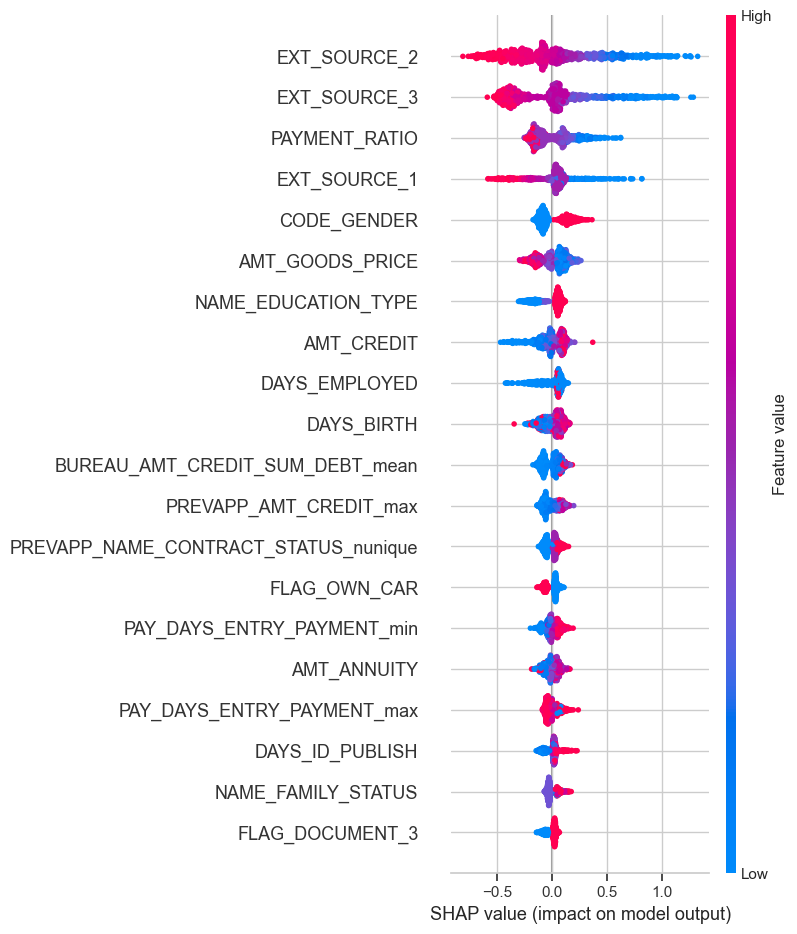

In [40]:
# SHAP explainability (sample on best fold model)
# We'll train a smaller model on full train for SHAP sample (or reuse last fold model object if present)
small_clf = lgb.LGBMClassifier(**{k:v for k,v in params.items() if k in ['learning_rate','num_leaves','n_jobs','seed']}, n_estimators=200)
small_clf.fit(train_X, y)
explainer = shap.TreeExplainer(small_clf)
shap_values = explainer.shap_values(train_X.sample(1000, random_state=RANDOM_STATE))

# summary plot (this will open interactive plot in some environments)
shap.summary_plot(shap_values, train_X.sample(1000, random_state=RANDOM_STATE))

# **6. Evaluation Model**

Gender 1: AUC = 0.7637 (n=105059)
Gender 0: AUC = 0.7689 (n=202448)
   bucket      mean  count
0       0  0.010829  30752
1       1  0.017040  30751
2       2  0.025593  30751
3       3  0.033202  30751
4       4  0.044454  30751
5       5  0.057592  30751
6       6  0.077331  30751
7       7  0.106208  30751
8       8  0.149686  30751
9       9  0.285357  30751


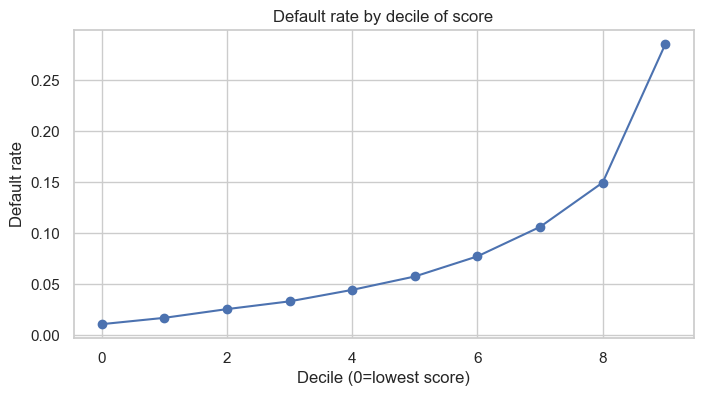

In [41]:
# Simple fairness check: AUC by gender
if 'CODE_GENDER' in train_X.columns:
    genders = train_X['CODE_GENDER'].unique()
    for g in genders:
        idx = train_X['CODE_GENDER']==g
        if idx.sum() > 50:
            auc_g = roc_auc_score(y[idx], oof_preds[idx])
            print(f'Gender {g}: AUC = {auc_g:.4f} (n={idx.sum()})')

# Business rule example: Build risk buckets and show expected default rate
train_scores = pd.DataFrame({'SK_ID_CURR': train_ids, 'score': oof_preds, 'target': y})
train_scores['bucket'] = pd.qcut(train_scores['score'], 10, labels=False)
br = train_scores.groupby('bucket')['target'].agg(['mean','count']).reset_index().sort_values('bucket')

# Visualization Result
print(br) 

plt.figure(figsize=(8,4))
plt.plot(br['bucket'], br['mean'], marker='o') 
plt.title('Default rate by decile of score')
plt.xlabel('Decile (0=lowest score)')
plt.ylabel('Default rate')
plt.show()

# **7. Export & Save Model**

In [42]:
# Create submission file
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': sub_preds})
submission.to_csv(OUTPUT_DIR / 'submission_lgb_cv.csv', index=False)
print('Submission saved to', OUTPUT_DIR / 'submission_lgb_cv.csv')

# Save model
final_model = lgb.LGBMClassifier(**{k:v for k,v in params.items() if k in ['learning_rate','num_leaves','n_jobs','seed']}, n_estimators=clf.best_iteration)
final_model.fit(train_X, y)
import joblib
joblib.dump(final_model, OUTPUT_DIR / 'final_model.joblib')
print('Final model saved')

Submission saved to models\submission_lgb_cv.csv
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.426335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17021
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Final model saved


# **8. Output Analysis**

# **9. Output Recommendation**